# Afinn Sentiment Calculations

This notebook was used to generate sentiment tags for tweet messages and apply the alignment measures to Afinn tags. 

In [1]:
import pandas as pd
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import re
import seaborn as sns 
from collections import Counter

from afinn import Afinn

# Import the SCP and LLR code
import SCP_Code as scp
import FunctionsForLLR as llr

In [3]:
# Import tag data

tagdataA = pd.read_csv('A_Tweets_Tagged.txt', sep='\t', header=None)
tagdataA.columns = ['Tokens', 'Tags', 'Conf','Raw Tweet']
tagdataB = pd.read_csv('B_Tweets_Tagged.txt', sep='\t', header=None)
tagdataB.columns = ['Tokens', 'Tags', 'Conf','Raw Tweet']

In [8]:
# Function to generate Afinn sentiment tags for each tweet set

def getAfinnSentiment(tweetset):
    afinn = Afinn(emoticons=True) # Set emoticons to true because Twitter domain
    templist = [] # create empty list with which to append sentiment score of sentence/tweet
    for tweet in tweetset: # tweetset will be dataframe['Tokens']
        templist.append(afinn.score(tweet))
    return templist

In [7]:
# Fill empty tokens with word with a neutral sentiment value
tagdataA.fillna({'Tokens':'null'}, inplace=True)
tagdataB.fillna({'Tokens':'null'}, inplace=True)

In [9]:
aAfinnSent = getAfinnSentiment(tagdataA.Tokens)
bAfinnSent = getAfinnSentiment(tagdataB.Tokens)

In [10]:
print(len(aAfinnSent),len(bAfinnSent))

326168 326167


In [11]:
AfinnDF = pd.DataFrame(aAfinnSent)#, columns = 'A Afinn')
AfinnDF.columns = ['ASentimentValue']

In [12]:
AfinnDF_b = pd.DataFrame(bAfinnSent)#, columns = 'A Afinn')
AfinnDF_b.columns = ['BSentimentValue']
AfinnDF['BSentimentValue'] = AfinnDF_b['BSentimentValue']
AfinnDF.head()

,ASentimentValue,BSentimentValue
0,0.0,3.0
1,0.0,2.0
2,2.0,0.0
3,0.0,-1.0
4,-3.0,0.0


In [13]:
# Drop last item in dataframe because it only has a-value
AfinnDF.drop(326167,inplace=True)
len(AfinnDF)

326167

In [20]:
# Drop middle values with -1,0,1 to filter out noise and create a dataset that only contains values outside of the 
# range (-1,1)
AfinnDF_Signif = AfinnDF.copy()
AfinnDF_Signif = AfinnDF_Signif[AfinnDF_Signif.ASentimentValue != 0]
AfinnDF_Signif = AfinnDF_Signif[AfinnDF_Signif.ASentimentValue != 1]
AfinnDF_Signif = AfinnDF_Signif[AfinnDF_Signif.ASentimentValue != -1]
print(len(AfinnDF_Signif))
AfinnDF_Signif.head()

170322


,ASentimentValue,BSentimentValue
2,2.0,0.0
4,-3.0,0.0
7,-3.0,0.0
11,2.0,3.0
13,-7.0,0.0


In [124]:
print('Max: ', AfinnDF_Signif.max())
print('Min: ', AfinnDF_Signif.min())

Max:  SentimentValue     30.0
BSentimentValue    22.0
dtype: float64
Min:  SentimentValue    -37.0
BSentimentValue   -21.0
dtype: float64


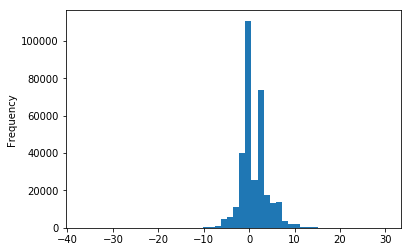

In [24]:
plot = AfinnDF['ASentimentValue'].plot(kind = 'hist', bins=50)
plt.savefig('Afinn_SentDistrib.png')

### Run below box to generate a set of positive and negative replacement values
This creates a binary system in which sentiments are matching or not matching in each set with tags P-Positive, N-Negative, and null for noise. 

In [25]:
replacesetPos = list(range(2,31))
print(replacesetPos)
replacesetNeg = list(range(-37,-1))
print(replacesetNeg)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[-37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2]


In [ ]:
AfinnSubsDF = AfinnDF_Signif.replace(replacesetPos,'P')
AfinnSubsDF.head()

In [ ]:
AfinnSubsDF = AfinnSubsDF.replace(replacesetNeg,'N')
AfinnSubsDF.head()

In [ ]:
# Replace -1,0,1
AfinnSubsDF = AfinnSubsDF.replace(-1,'null')
AfinnSubsDF.head()

In [31]:
#AfinnBOnly = pd.DataFrame()
AfinnBOnly = AfinnSubsDF.copy()
AfinnBOnly.drop(['ASentimentValue'],axis = 1, inplace = True)
AfinnBOnly.head()

,BSentimentValue
2,null
4,null
7,null
11,P
13,null


In [32]:
AfinnAOnly = AfinnSubsDF.copy()
AfinnAOnly.drop(['BSentimentValue'],axis = 1, inplace = True)
AfinnAOnly.head()

,ASentimentValue
2,P
4,N
7,N
11,P
13,N


In [34]:
sentimentSet = ['P','N']

In [35]:
# Function below is specifically for Afinn and finding matching sentiment values. 
def getSharedMark(tweetset):
    sharedMarkers = []
    row_iterator = tweetset.iterrows()
    for row in row_iterator:
        if row[1][0] == row[1][1]:
            sharedMarkers.append(row[1][0])
        else:
            sharedMarkers.append('-')
    return sharedMarkers


In [36]:
# Get shared and shuffled shared sentiment markers

sharedSentimentAB = getSharedMark(AfinnSubsDF)
shuffledBSent = random.sample(AfinnSubsDF['BSentimentValue'],len(AfinnSubsDF['BSentimentValue']))
sharedRandSentAnB = getSharedMarkers(AfinnSubsDF['SentimentValue'],shuffledBSent)
print(len(AfinnSubsDF),len(sharedSentimentAB))

170322 170322


In [261]:
AfinnSubsDF.head()

,SentimentValue,BSentimentValue
2,P,null
4,N,null
7,N,null
11,P,P
13,N,null


In [37]:
shuffledBSent = AfinnSubsDF['BSentimentValue'].tolist()
print(shuffledBSent[0:5])
shuffledBSent = random.sample(shuffledBSent,len(shuffledBSent))
#shuffledBSent = shuffledBSent.drop(['SentimentValue'], axis=1)
#shuffledBSent.head()
randDF = AfinnSubsDF.copy()
randDF = randDF.drop('BSentimentValue',axis = 1)
randDF['BSentRand'] = shuffledBSent
randDF.head() # why is 1 showing up?

['null', 'null', 'null', 'P', 'null']


,ASentimentValue,BSentRand
2,P,P
4,N,P
7,N,N
11,P,P
13,N,null


In [38]:
sharedRandSentAnB = getSharedMark(randDF)
sharedRandSentAnB[0:5]

['P', '-', 'N', 'P', '-']

In [253]:
print(sharedSentimentAB[0:10])
tal=0
for item in sharedSentimentAB[0:10]:
    if item != '-':
        tal+=1
print(tal)

['-', '-', '-', 'P', '-', '-', 'N', '-', '-', 'N']
3


In [280]:
SentSCP = scp.CalculateAllCohesion(sentimentSet,sharedSentimentAB,sharedRandSentAnB)
SentSCP

{'P': [0.20042493569245204, 0.18002127744376348, 0.02040365824868856],
 'N': [0.030091946763467794, 0.017212041684167925, 0.01287990507929987]}

In [281]:
CohesionDF = pd.DataFrame.from_dict(SentSCP,orient = 'index')
CohesionDF.columns = ['TweetReply Cohesion', 'RandomReply Cohesion', 'Subtractive Cohesion Score']
CohesionDF.head()

,TweetReply Cohesion,RandomReply Cohesion,Subtractive Cohesion Score
P,0.200425,0.180021,0.020404
N,0.030092,0.017212,0.012880


In [282]:
CohesionToPlot = CohesionDF.copy()
CohesionToPlot.drop(['TweetReply Cohesion'],axis = 1, inplace = True)
CohesionToPlot.drop(['RandomReply Cohesion'],axis = 1, inplace = True)
CohesionToPlot

,Subtractive Cohesion Score
P,0.020404
N,0.012880


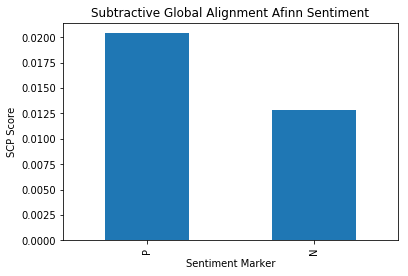

In [285]:
plot1 = CohesionToPlot.plot(kind = 'bar',legend = False)#,figsize = (20,10))
                    
#plot1.tick_params(labelbottom=False, bottom=False,which='both')
plt.ylabel('SCP Score')
plt.xlabel('Sentiment Marker')
plt.title('Subtractive Global Alignment Afinn Sentiment')
plt.savefig('SCP_Sentiment_Afinn')

# Linguistic Style Matching

In [299]:
def CalculateLSM(markers,TweetTagsA,TweetTagsB):
    allLSM = {}
    allTweets = len(AfinnSubsDF) # total number of tweets
    for mark in markers: 
        pA = (scp.countMarkers(mark,TweetTagsA)/allTweets)
        pB = (scp.countMarkers(mark,TweetTagsB)/allTweets)
        numerator = abs(pA-pB)
        denominator = pA + pB
        LSMScore = (1 - (numerator/denominator))
        allLSM[mark] = [pA,pB,LSMScore]
    return allLSM

In [309]:
LSM_Sentiment = CalculateLSM(sentimentSet, AfinnSubsDF['SentimentValue'],AfinnSubsDF['BSentimentValue'])
LSM_Sentiment

{'P': [0.7410786627681685, 0.4647843496436162, 0.7708742118460452],
 'N': [0.25892133723183147, 0.12698300865419618, 0.6581061343719572]}

In [310]:
LSMdf = pd.DataFrame.from_dict(LSM_Sentiment,orient = 'index')
LSMdf.columns = ['pA', 'pB','LSM Score']
LSMdf

,pA,pB,LSM Score
P,0.741079,0.464784,0.770874
N,0.258921,0.126983,0.658106


In [311]:
# Write dataframe to latex
with open ('LSMTable_SentimentAfinn.tex','w') as tf:
    tf.write(LSMdf.to_latex())

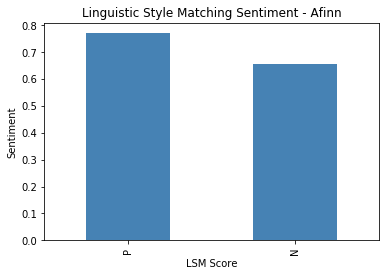

In [313]:
# Visualize dataframe to horizontal bar chart
plot1 = LSMdf['LSM Score'].plot(kind = 'bar',legend = False, color = 'steelblue')#,figsize = (20,10))
                    
#plot1.tick_params(labelbottom=False, bottom=False,which='both')
plt.xlabel('LSM Score')
#plt.xlim(0.85,1.005)
plt.ylabel('Sentiment')
plt.title('Linguistic Style Matching Sentiment - Afinn')
plt.savefig('LSM_Sentiment_Afinn')

# LLR - Log Likelihood Ratio

In [314]:
LLR_Sent = llr.getLLR(AfinnSubsDF['SentimentValue'],AfinnSubsDF['BSentimentValue'],sharedSentimentAB,sentimentSet)
LLR_Sent

AMarker - N1:  126222  ANoMarker - N2:  44100
AMarker - N1:  44100  ANoMarker - N2:  126222


{'P': 5656.843197025562, 'N': 4444.736386187084}

In [315]:
LLR_Rand_Sent = llr.getLLR(AfinnSubsDF['SentimentValue'],AfinnSubsDF['BSentimentValue'],sharedRandSentAnB,sentimentSet)
LLR_Rand_Sent

AMarker - N1:  126222  ANoMarker - N2:  44100
AMarker - N1:  44100  ANoMarker - N2:  126222


{'P': 0.31982682400848716, 'N': 0.054454983794130385}

In [316]:
LLRSentDF = pd.DataFrame.from_dict(LLR_Sent, orient='index')
LLRSentDF.columns = ['LLR Scores Sentiment']
LLRSentDF.head()

,LLR Scores Sentiment
P,5656.843197
N,4444.736386


In [321]:
LLR_RandDF = pd.DataFrame.from_dict(LLR_Rand_Sent, orient='index')
LLR_RandDF.columns = ['LLR Rand Sentiment']
LLR_RandDF

,LLR Rand Sentiment
P,0.319827
N,0.054455


In [324]:
LLR_RandDF = LLR_RandDF.rename(index = {'P':'P_Rand','N':'N_Rand'})

In [325]:
LLR_RandDF = LLR_RandDF.rename(columns = {'LLR Rand Sentiment':'LLR Scores Sentiment'})

In [327]:
LLRSentDF=LLRSentDF.append(LLR_RandDF)
LLRSentDF

,LLR Scores Sentiment
P,5656.843197
N,4444.736386
P_Rand,0.319827
N_Rand,0.054455


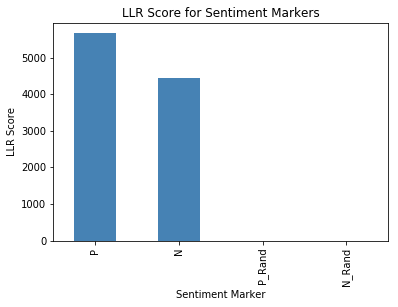

In [329]:
# Visualize dataframe to horizontal bar chart
plot1 = LLRSentDF['LLR Scores Sentiment'].plot(kind = 'bar', stacked = True, color = 'SteelBlue')#,figsize = (20,10))
                    
#plot1.tick_params(labelbottom=False, bottom=False,which='both')
plt.ylabel('LLR Score')
plt.xlabel('Sentiment Marker')
plt.title('LLR Score for Sentiment Markers')
plt.savefig('LLRScores_Sentiment')

In [330]:
with open ('LLRSentDF.tex','w') as tf:
    tf.write(LLRSentDF.to_latex())